In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone_SpotifyStreaming/notebooks

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

#from library.sb_utils import save_file



Mounted at /content/drive
/content/drive/MyDrive/Capstone_SpotifyStreaming/notebooks


In [2]:
# load the feature matrix to check whether it was properly saved.

feature_matrix = pd.read_csv('../data/processed/feature_matrix.csv')
feature_matrix.head().T

,0,1,2,3,4
event_id,0,20,40,60,80
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_0000a72b-09ac-412f-b452-9b9e79bded8f,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0_00016a3d-9076-4f67-918f-f29e3ce160dc,0_00018b58-deb8-4f98-ac5e-d7e01b346130
session_position,1,1,1,1,1
skip_1,False,False,False,True,False
skip_2,False,True,False,True,False
...,...,...,...,...,...
DIFF(tf.time_signature_3) by session_id,NaN,NaN,NaN,NaN,NaN
DIFF(tf.time_signature_4) by session_id,NaN,NaN,NaN,NaN,NaN
DIFF(tf.time_signature_5) by session_id,NaN,NaN,NaN,NaN,NaN
DIFF(tf.us_popularity_estimate) by session_id,NaN,NaN,NaN,NaN,NaN


In [3]:
feature_matrix.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('bool'), dtype('float64')],
      dtype=object)

In [4]:
feature_matrix.columns[feature_matrix.dtypes=='O']

Index(['session_id', 'tf.MODE(log.session_id)'], dtype='object')

# Train/test data split

In this case ,there are 3 ways of splitting the data.


1.   **Randomly split the data by row, regardless the session and order information.** This is the most conventional approach.
2.   **Extract the last few tracks of each session as test dataset.** This approach focuses on whether the model can predict the next track being skipped according to its preceeding history.
3.   **Randomly select all the rows of a few sessions as test dataset.** This approach focuses on whether the listening behavior is generalizable to different sessions.





# Random split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3','session_id','CUM_COUNT(session_id) by session_id','CUM_COUNT(track_id_clean) by session_id', 'tf.MODE(log.session_id)', 'session_position']), 
                                                    feature_matrix['not_skipped'], test_size=0.2, 
                                                    random_state=47,stratify=feature_matrix['not_skipped'])

In [6]:
print('X_train.shape: ',X_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_train.shape: ',y_train.shape)
print('y_test.shape: ',y_test.shape)

X_train.shape:  (134304, 596)
X_test.shape:  (33576, 596)
y_train.shape:  (134304,)
y_test.shape:  (33576,)


In [7]:
X_test.head()

,event_id,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_is_shuffle,hour_of_day,premium,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,...,DIFF(tf.release_year) by session_id,DIFF(tf.speechiness) by session_id,DIFF(tf.tempo) by session_id,DIFF(tf.time_signature_0) by session_id,DIFF(tf.time_signature_1) by session_id,DIFF(tf.time_signature_3) by session_id,DIFF(tf.time_signature_4) by session_id,DIFF(tf.time_signature_5) by session_id,DIFF(tf.us_popularity_estimate) by session_id,DIFF(tf.valence) by session_id
3635,61072,0,0,0,0,True,12,False,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43147,52788,0,0,1,1,False,8,True,0,0,...,0.0,0.005295,20.072006,0.0,0.0,0.0,0.0,0.0,2.062224,-0.180481
131621,144416,0,1,0,0,True,8,True,0,0,...,0.0,0.002391,1.003998,0.0,0.0,0.0,0.0,0.0,0.009362,-0.105128
659,11121,0,0,0,0,False,13,True,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47503,125948,0,1,0,0,True,13,True,0,0,...,1.0,-0.030987,-59.915001,0.0,0.0,0.0,0.0,0.0,-0.000574,0.071088


In [8]:
y_test.head()

3635      False
43147     False
131621    False
659       False
47503     False
Name: not_skipped, dtype: bool

In [9]:
skf = StratifiedKFold(n_splits=5)
skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [10]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=23)
)
rf_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=skf, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.4min finished


In [12]:
rf_cv_scores = rf_cv_results['test_score']
rf_cv_scores

array([1., 1., 1., 1., 1.])

In [13]:
rf_cv_results

{'fit_time': array([125.82919288, 118.64479423, 126.09402227, 118.32470322,
        118.53504491]),
 'score_time': array([2.99903584, 3.10525823, 2.46587491, 2.67223239, 2.42613626]),
 'test_score': array([1., 1., 1., 1., 1.])}

In [ ]:
plt.subplots(figsize=(10, 5))
rf_cv_results.

imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

                                                   IMPORTANCE
FEATURE                                                      
CUM_MEAN(acous_rmse_to_mean_noskip) by session_id       0.145
CUM_SUM(acous_rmse_to_mean_noskip) by session_id        0.138
CUM_MIN(acous_rmse_to_mean_noskip) by session_id        0.126
acous_rmse_to_mean_noskip                               0.115
CUM_MAX(acous_rmse_to_mean_noskip) by session_id        0.104
...                                                       ...
tf.MAX(log.acous_rmse_to_previous)                      0.000
tf.MAX(log.acous_rmse_to_mean)                          0.000
tf.MAX(log.acous_mah_dist_to_previous)                  0.000
tf.MAX(log.acous_mah_dist_to_mean)                      0.000
DIFF(tf.valence) by session_id                          0.000

[596 rows x 1 columns]


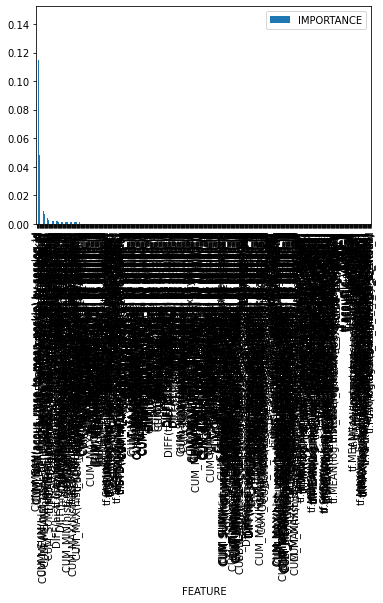

In [20]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train2 = imp_median.fit_transform(X_train)
forest = RandomForestClassifier(random_state=0)

forest.fit(X_train2, y_train)

importances = pd.DataFrame({'FEATURE':X_train2.columns,'IMPORTANCE':np.round(forest.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

print(importances)
importances.plot.bar()
plt.show()

In [22]:
print(importances[0:50])

                                                    IMPORTANCE
FEATURE                                                       
CUM_MEAN(acous_rmse_to_mean_noskip) by session_id        0.145
CUM_SUM(acous_rmse_to_mean_noskip) by session_id         0.138
CUM_MIN(acous_rmse_to_mean_noskip) by session_id         0.126
acous_rmse_to_mean_noskip                                0.115
CUM_MAX(acous_rmse_to_mean_noskip) by session_id         0.104
DIFF(acous_rmse_to_mean_noskip) by session_id            0.048
tf.PERCENT_TRUE(log.not_skipped)                         0.033
hist_user_behavior_reason_start_trackdone                0.030
tf.PERCENT_TRUE(log.skip_3)                              0.023
tf.SUM(log.acous_rmse_to_mean_noskip)                    0.016
hist_user_behavior_reason_start_fwdbtn                   0.014
CUM_SUM(hist_user_behavior_reason_start_trackdo...       0.011
CUM_MEAN(hist_user_behavior_reason_start_trackd...       0.009
tf.MIN(log.acous_rmse_to_mean_noskip)                  